# **Tutorial on using BERT for Requirements Classification**

This tutorial is part of the Technicak Briefing track at ICSE'21, the presented article's: ***NLP for Requirements Engineering: Tasks, Techniques, Tools and Technologies*** by Alessio Ferrai, Liping Zhao and Waad Alhoshan




Requirement classification is considered an essential NLP4RE task for many RE systems. For example, to classify requirements as functional or non-functional or to apply fine-grained analysis and classify requirements with multi-labels. This tutorial will spot the light on classyfing requirements using a state-of-the-art model namely BERT. 

The used dataset link https://www.kaggle.com/iamsouvik/software-requirements-dataset?select=nfr.txt

### Step 1: Dataset Preparation and Preprocessing

In [ ]:
import pandas as pd
df = pd.read_csv('', sep=';', encoding = "ISO-8859-1")
df.head()


,Class,Requirement
0,PE,The system shall refresh the display every 60 seconds.
1,LF,The application shall match the color of the schema set forth by Department of Homeland Security
2,US,If projected the data must be readable. On a 10x10 projection screen 90% of viewers must be able to read Event / Activity data from a viewing distance of 30
3,A,The product shall be available during normal business hours. As long as the user has access to the client PC the system will be available 99% of the time during the first six months of operation.
4,US,If projected the data must be understandable. On a 10x10 projection screen 90% of viewers must be able to determine that Events or Activities are occuring in current time from a viewing distance of 100


Check the labels distribution in the dataset

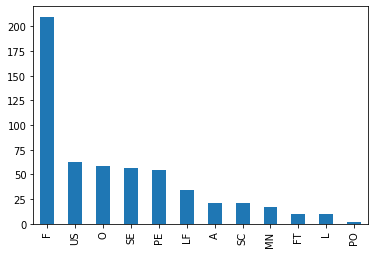

In [ ]:
df['Class'].value_counts().plot(kind='bar')

Tokenized dataset into two parts to be ready for BERT processing


In [ ]:
import numpy as np

seq_len = 512
num_samples = len(df)

# initialize empty zero arrays
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

# check shape
Xids.shape

(556, 512)

Use BERT tokenizer 

In [ ]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i, phrase in enumerate(df['Requirement']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    # assign tokenized outputs to respective rows in numpy arrays
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

For efficiency, we can remove the files from the memory and save them into NP binary files

In [ ]:

with open('Req-xids.npy', 'wb') as f:
    np.save(f, Xids)
with open('Req-xmask.npy', 'wb') as f:
    np.save(f, Xmask)

Extract the labels from the dataset 

In [ ]:
'''
# first extract sentiment column

# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape
labels[np.arange(num_samples), arr] = 1
labels
'''
labels = df['Class'].values
labels.shape

(556,)

Another optional step for optiomization 

In [ ]:
with open('Req-labels.npy', 'wb') as f:
    np.save(f, labels)

import saved binary files 

In [ ]:
import numpy as np

with open('Req-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('Req-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('Req-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

 create a TF dataset object with them using from_tensor_slices and modify the object for better processing

In [ ]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, ()), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.string)>

Shuffle the dataset and batch it (with size 16) and remove any sample that doesn't fit to the batch size

In [ ]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.string)>

Split the dataset into train and validate 

In [ ]:
split = 0.9
# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)
size
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

Save the prepared the dataset 

In [ ]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')
train_ds.element_spec
val_ds.element_spec == train_ds.element_spec
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

### Step 2: Build and Train The Classifier Model

First, we can initialize the Bert model, which we will load as a pretrained model from transformers.

In [ ]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-uncased')
# we can view the model using the summary method
bert.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________



Now we need to define the frame around Bert, we need:

* Two input layers (one for input IDs and one for attention mask).
* A post-bert dropout layer to reduce the likelihood of overfitting and improve * generalization.
* Max pooling layer to convert the 3D tensors output by Bert to 2D.
* Final output activations using softmax for outputting categorical probabilities.

In [ ]:

import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # access final activations with [0]

# convert bert embeddings into 5 output classes
x = tf.keras.layers.LSTM(32, dropout=.3, recurrent_dropout=.3, return_sequences=True)(embeddings)
x = tf.keras.layers.LSTM(16, dropout=.4, recurrent_dropout=.4, return_sequences=False)(x)
# normalize
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dense(64, activation='relu')(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
# (optional) freeze bert layer
model.layers[2].trainable = False
# print out model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 512, 32)      102528      bert[0][0]                 

Our model architecture is now setup, and we can initialize our training parameters like so:

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])


Now all we need to do is train our model.

In [ ]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))
# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)
# view the input format
train_ds.take(1)


<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

test

In [ ]:
model.save('Req_model')

INFO:tensorflow:Assets written to: Req_model/assets


INFO:tensorflow:Assets written to: Req_model/assets


### Step 3: Load and Use the Model

We've now built our model, trained it, and saved it to file - now we can begin applying it to making predictions. First, we load the model with tf.keras.models.load_model

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('Req_model')
# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 512, 32)      102528      bert[0][0]                 

Before making our predictions we need to format our data, which requires two steps:

* Tokenizing the data using the bert-base-cased tokenizer.
* Transforming the data into a dictionary containing 'input_ids' and 'attention_mask' tensors.

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

probs = model.predict(prep_data("The screen has nice color"))[0]

probs


import numpy as np

np.argmax(probs)


0

In [ ]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('Requirement_Test.csv', sep=';')
df.head()

,Class,Requirement
0,F,The system shall display Events or Activities.
1,F,The display shall have two regions
2,F,The data displayed in both the nodes within the graph and the rows in the table are MSEL Summary data
3,F,The table side of the display shall be split into 2 regions
4,F,The top 1/4 of the table will hold events that are to occur sequentially.


In [ ]:
df['Class'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Requirement'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Predicated_Class'] = pred

df.head()

,Class,Requirement,Predicated_Class
0,None,The system shall display Events or Activities.,2.0
1,None,The display shall have two regions,1.0
2,None,The data displayed in both the nodes within the graph and the rows in the table are MSEL Summary data,2.0
3,None,The table side of the display shall be split into 2 regions,1.0
4,None,The top 1/4 of the table will hold events that are to occur sequentially.,2.0


Reference: https://github.com/jamescalam/transformers/blob/main/course/project_build_tf_sentiment_model/03_load_and_predict.ipynb